In [1]:
import os
os.chdir("..")

In [2]:
import time
import pandas as pd
from lightning_lite.utilities.seed import seed_everything
from shell_data.dataset.dataset import get_train_val_test_subsets
import torch
import os
from shell_data.utils.config import (
    ShELLDataSharingConfig,
    DatasetConfig,
    TaskModelConfig,
    TrainingConfig,
    ExperienceReplayConfig,
    DataValuationConfig,
    RouterConfig,
    BoltzmanExplorationConfig,
)
from shell_data.utils.record import Record, snapshot_perf, snapshot_conf_mat
import numpy as np
from shell_data.shell_agent.shell_agent_classification import ShELLClassificationAgent
from itertools import combinations
import umap
from copy import deepcopy
from functools import partial


from shell_data.utils.utils import train
import matplotlib.pyplot as plt
# import mplcyberpunk
# plt.style.use("cyberpunk")
# plt.style.use('bmh')
import seaborn as sns
plt.style.use("fivethirtyeight")
# plt.style.use("xkcd")
sns.set_style("whitegrid")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import random
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
torch.use_deterministic_algorithms(True)

SEED = 69
seed_everything(SEED)

2023-02-06 13:20:00.950702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 13:20:01.511394: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-06 13:20:01.511443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-06 13:20:01.511447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

69

In [3]:
from shell_data.task_model.task_model import TaskModel, SupervisedLearningTaskModel
import torch.nn as nn

## Setup

In [4]:
num_cls_per_task = 5
n_agents = 2
num_task_per_life = 2
buffer_integration_size = 50000  # sample all!
batch_size = 32
size = 64
routing_method = "random"

dataset_name = "mnist"

In [5]:
train_subsets, val_subsets, test_subsets = get_train_val_test_subsets(
        dataset_name)

In [6]:
cfg = ShELLDataSharingConfig(
        n_agents=n_agents,
        dataset=DatasetConfig(
            name=dataset_name,
            train_size=size,
            test_size=1.0,
            val_size=size//2,
            num_task_per_life=num_task_per_life,
            num_cls_per_task=num_cls_per_task,
        ),
        task_model=TaskModelConfig(
            name=dataset_name,
        ),
        training=TrainingConfig(
            n_epochs=50,
            batch_size=batch_size,
            patience=1000,
            val_every_n_epoch=1,
        ),
        experience_replay=ExperienceReplayConfig(
            buffer_size=buffer_integration_size,
        ),
          router=RouterConfig(
            strategy=routing_method,  # control how the sender decides which data point to send
            num_batches=1,
            estimator_task_model=TaskModelConfig(
                name=dataset_name,
            ),
            n_heads=n_agents,
          ),
    )

In [7]:
receiver = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, cfg)

train_size: 64, num_cls_per_task: 5


In [8]:
sender_cfg = deepcopy(cfg)
# sender_cfg.dataset.train_size = 1.0 # all of the data for testing purposes...
sender = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, sender_cfg)

train_size: 64, num_cls_per_task: 5


In [9]:
receiver.ll_dataset.perm = torch.tensor([0, 1, 3, 4, 9,     2, 5, 6, 7, 8])
sender.ll_dataset.perm = torch.tensor([0, 4, 9, 2, 5,       1, 3, 6, 7, 8])

# intersection be 0, 4, 9 (and 2 out of distribution!)

receiver.init_model_router()
sender.init_model_router()

## AutoEncoder

In [10]:
class MNISTAutoEncoder(nn.Module):
    """
    Auto-encoder in order to do 
    (1) image similarity search by computing the distance 
    between the latent representations.
    (2) outlier detection by computing the reconstruction error.
    """
    def __init__(self) -> None:
        # use architecture here 
        # https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),  # b, 8, 2, 2
        )
        # output size: 8 * 2 * 2 = 32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid(),
        )


    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
from typing import (
    Optional,
    Union,
    Tuple,
)

class ReconstructionTaskModel(TaskModel):
    def __init__(self):
        self.net = MNISTAutoEncoder()
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        self.device = "cuda"
        self.net.to(self.device)
    

    def train_step(self, batch: Tuple[torch.Tensor, torch.Tensor], head_id=None):
        x, _ = self.to_device(batch)
        self.net.train()
        self.optimizer.zero_grad()
        reconstructed = self.net(x)
        loss = self.criterion(reconstructed, x)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor]):
        x, _ = self.to_device(batch)
        self.net.eval()
        with torch.no_grad():
            reconstructed = self.net(x)
            loss = self.criterion(reconstructed, x)
        return loss.item()
    
    def val_step(self, batch) -> float:
        return self.test_step(batch)

In [12]:
autoencoder = ReconstructionTaskModel()

In [13]:
receiver_data = receiver.ll_dataset.get_train_dataset(0, kind="all")
len(receiver_data)

320

In [14]:
sender_data = sender.ll_dataset.get_train_dataset(0, kind="all")
len(sender_data)

320

In [15]:
train_dataloader = torch.utils.data.DataLoader(
    receiver_data,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

In [16]:
def val_func(early_stopping, global_step, epoch, train_loss, record):
    print(f"Epoch: {epoch}, global_step: {global_step}, train_loss: {train_loss}")
    # total_train_loss = train on the entire dataset

    total_dataloader = torch.utils.data.DataLoader(
        receiver_data, batch_size=len(receiver_data), shuffle=False, num_workers=0, pin_memory=True
    )
    total_batch = next(iter(total_dataloader))
    total_loss = autoencoder.test_step(total_batch)
    record.write({
        "epoch": epoch,
        "global_step": global_step,
        "train_loss": train_loss,
        "total_loss": total_loss
    })
    return early_stopping.step(total_loss)

In [17]:
record = Record("mnist_autoencoder.csv")

In [18]:
"""
https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac
Should train for about 30 epochs
"""
if os.path.exists("mnist_autoencoder.pt"):
    print("loading...")
    autoencoder.net.load_state_dict(torch.load("mnist_autoencoder.pt")) 
else:
    print('training...')
    train(autoencoder, train_dataloader, val_dataloader=None, n_epochs=500, val_every_n_epoch=1,
        patience=20, delta=0.0,
        val_func=partial(val_func, record=record), val_before=False);
    torch.save(autoencoder.net.state_dict(), "mnist_autoencoder.pt")
    record.save()

training...
Epoch: 0, global_step: 20, train_loss: 0.27561864256858826
Epoch: 1, global_step: 40, train_loss: 0.15221640467643738
Epoch: 2, global_step: 60, train_loss: 0.09555129706859589
Epoch: 3, global_step: 80, train_loss: 0.11683572828769684
Epoch: 4, global_step: 100, train_loss: 0.08435023576021194
Epoch: 5, global_step: 120, train_loss: 0.09749946743249893
Epoch: 6, global_step: 140, train_loss: 0.11744512617588043
Epoch: 7, global_step: 160, train_loss: 0.1104159727692604
Epoch: 8, global_step: 180, train_loss: 0.10783249884843826
Epoch: 9, global_step: 200, train_loss: 0.10573387145996094
Epoch: 10, global_step: 220, train_loss: 0.10118568688631058
Epoch: 11, global_step: 240, train_loss: 0.10537514835596085
Epoch: 12, global_step: 260, train_loss: 0.10944823920726776
Epoch: 13, global_step: 280, train_loss: 0.10308074951171875
Epoch: 14, global_step: 300, train_loss: 0.08885233849287033
Epoch: 15, global_step: 320, train_loss: 0.09384448826313019
Epoch: 16, global_step: 340

<AxesSubplot: xlabel='epoch'>

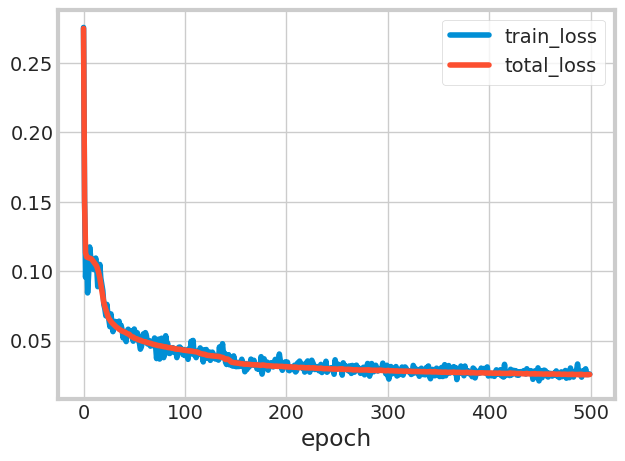

In [19]:
df = pd.read_csv(f"mnist_autoencoder.csv")
# shortened = df.iloc[15:]
df.plot(x="epoch", y=["train_loss", "total_loss"])

In [20]:
df["total_loss"].min()

0.0253675431013107

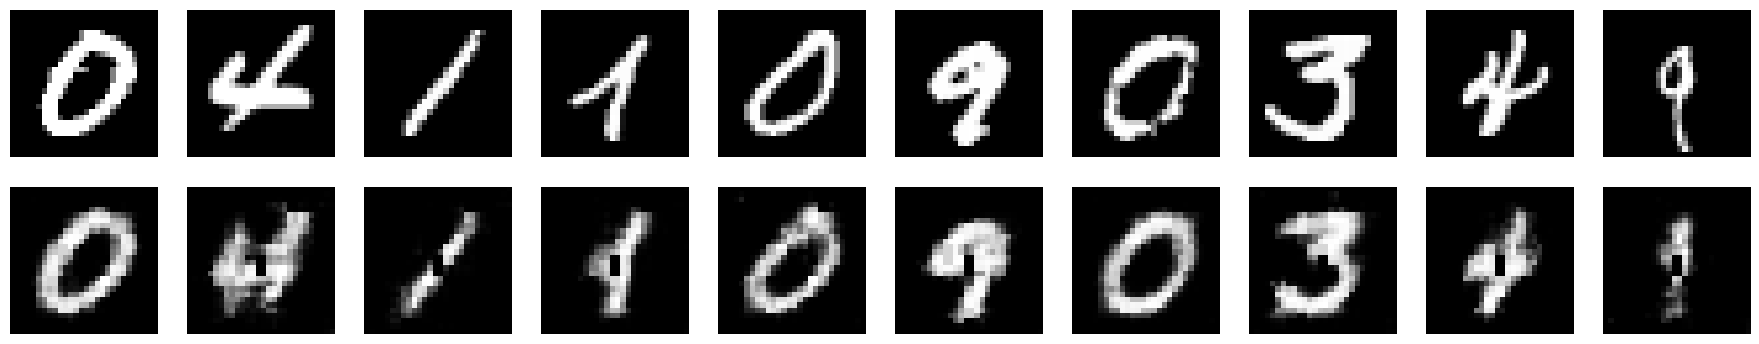

In [21]:
# pick some random images and see how the autoencoder reconstructs them
import matplotlib.pyplot as plt
import numpy as np

num_images = 10

rand_idx = np.random.randint(0, len(receiver_data), num_images)
images = [receiver_data[i][0] for i in rand_idx]

fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(20, 4))
for i, image in enumerate(images):
    axes[0, i].imshow(image.squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(autoencoder.net(image.unsqueeze(0).to(autoencoder.device)).squeeze().cpu().detach(), cmap="gray")
    axes[1, i].axis("off")

plt.show();

Reconstruction looks pretty good! Reconstruction error is about 0.02, which is what you'd expect for MNIST.

In [92]:
def to_features(X):
    return X.view(X.size(0), -1)

In [114]:

def clustering_reducer(reducer, X):
    return torch.tensor(reducer.transform(to_features(X).cpu().numpy()))

Maybe need other metric:
https://medium.com/analytics-vidhya/image-similarity-model-6b89a22e2f1a
(add tsne embedding on top of the encoded X) or use cosine similarity
instead of 2D distance!

In [93]:
def autoencoder_reducer(autoencoder, X):
    X = X.to(autoencoder.device)
    X = autoencoder.net.encoder(X)
    X = to_features(X)
    return X

In [206]:
import torch.nn.functional as F
def image_search(queries, database, reducer_callable, n_neighbors=10, p=2, metric="distance"):
    query_embed = reducer_callable(X=queries)
    database_embed = reducer_callable(X=database)
    if metric == "distance":
        dist = torch.cdist(query_embed, database_embed, p=p)
    elif metric == "cosine":
        dist = 1 - torch.stack([F.cosine_similarity(query_embed[i], database_embed) for i in range(len(query_embed))])
    else:
        raise ValueError(f"metric {metric} is not supported")
    closest_dist, closest_idx = torch.topk(dist, k=n_neighbors, dim=1, largest=False)
    return closest_dist, closest_idx

In [207]:
X_receiver = torch.stack([x for x, _ in receiver_data])
X_sender = torch.stack([x for x, _ in sender_data])

In [208]:
y_sender = torch.tensor([y for _, y in sender_data])
y_receiver = torch.tensor([y for _, y in receiver_data])

In [209]:
y_receiver

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

## Image search

In [210]:
"""
Pick some random images from receiver and plot the neighbors from sender
returned above
"""

def viz_image_search(queries, database, closest_idx, closest_dist):
    num_images = 10
    n_neighbors = 10
    x_idx = np.random.randint(0, len(queries), num_images)
    x = queries[x_idx]
    closest_idx = closest_idx[x_idx]

    fig, axes = plt.subplots(nrows=num_images, ncols=n_neighbors + 1, figsize=( 10, 12));
    for i, image in enumerate(x):
        axes[i, 0].imshow(image.cpu().squeeze(), cmap="gray");
        axes[i, 0].axis("off");
        for j in range(10):
            axes[i, j+1].imshow(database[closest_idx[i, j]].cpu().squeeze(), cmap="gray");
            axes[i, j+1].title.set_text(f"{closest_dist[i, j]:.2f}");
            axes[i, j+1].axis("off");
    
    plt.show();

In [211]:
def compute_img_search_quality(queries, database, query_y, database_y, closest_idx, n_neighbors=5):
    # for each query get the k nearest neighbors
    closest_idx = closest_idx.cpu()
    neighbor_idx = closest_idx[:, :n_neighbors]
    # compute the accuracy which is defined the fraction of database_y of neighbor_idx match with query_y
    neighbor_y = database_y[neighbor_idx]
    accuracy = (neighbor_y == query_y.unsqueeze(1)).sum(dim=1) / n_neighbors
    # accuracy per sample
    return accuracy

In [212]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.0, n_components=2, random_state=42)
reducer.fit(to_features(X_receiver).cpu())

UMAP(min_dist=0.0, n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

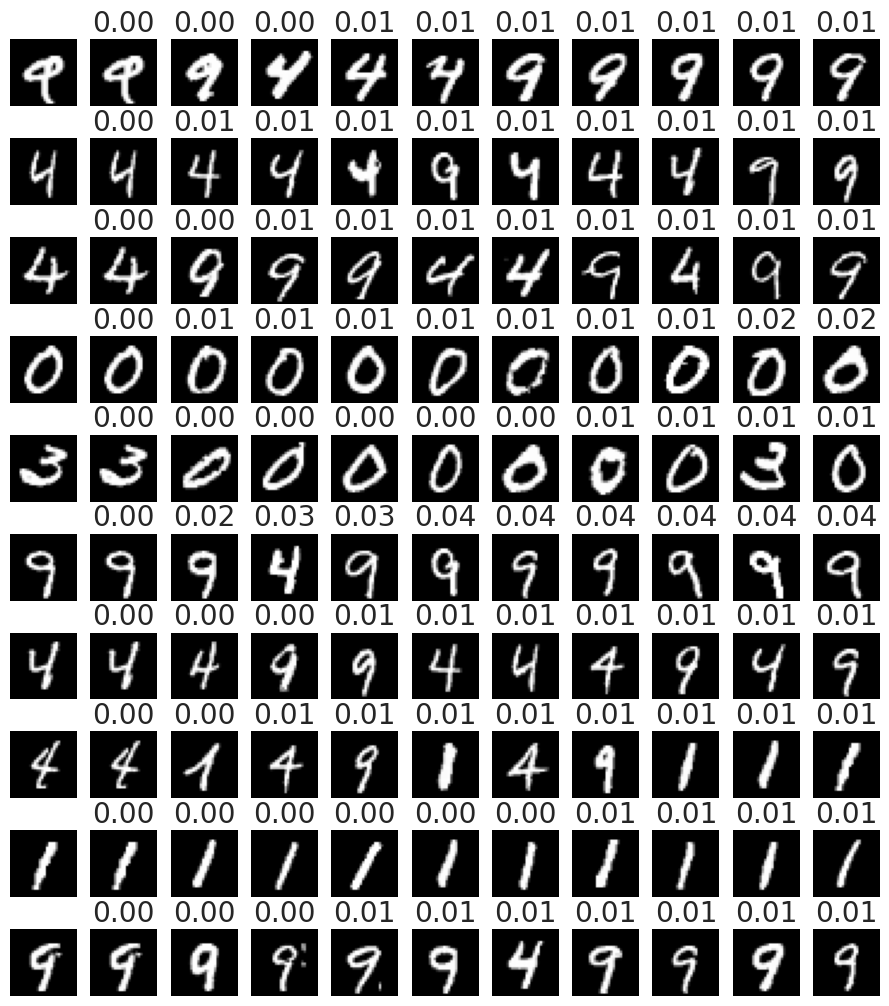

In [215]:
# training
closest_dist, closest_idx = image_search(X_receiver, X_receiver, reducer_callable=partial(autoencoder_reducer, autoencoder=autoencoder),
metric="cosine")
viz_image_search(X_receiver, X_receiver, closest_idx, closest_dist)

In [216]:
ae_training_retrieval_acc = compute_img_search_quality(X_receiver, X_receiver, y_receiver, y_receiver, closest_idx)
print(ae_training_retrieval_acc.mean())

tensor(0.8694)


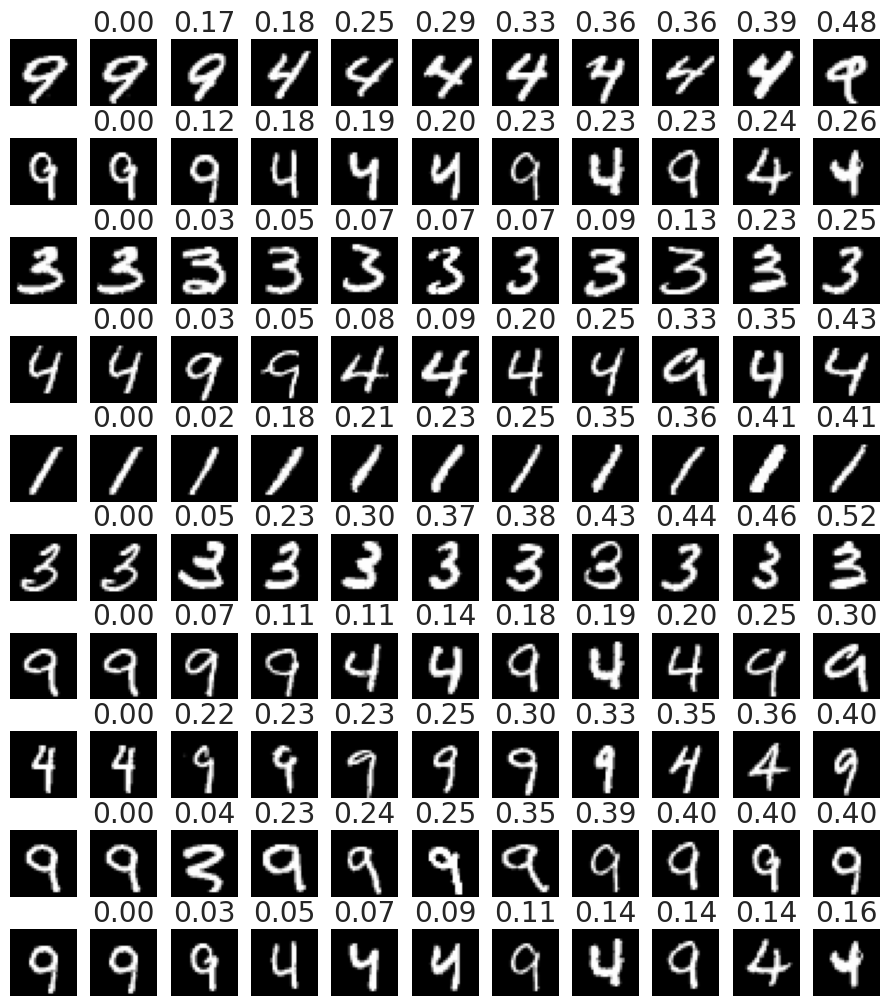

In [157]:
closest_dist, closest_idx = image_search(X_receiver, X_receiver, reducer_callable=partial(clustering_reducer, reducer=reducer))
viz_image_search(X_receiver, X_receiver, closest_idx, closest_dist)

In [158]:
clustering_training_retrieval_acc = compute_img_search_quality(X_receiver, X_receiver, y_receiver, y_receiver, closest_idx)
print(clustering_training_retrieval_acc.mean())

tensor(0.8606)


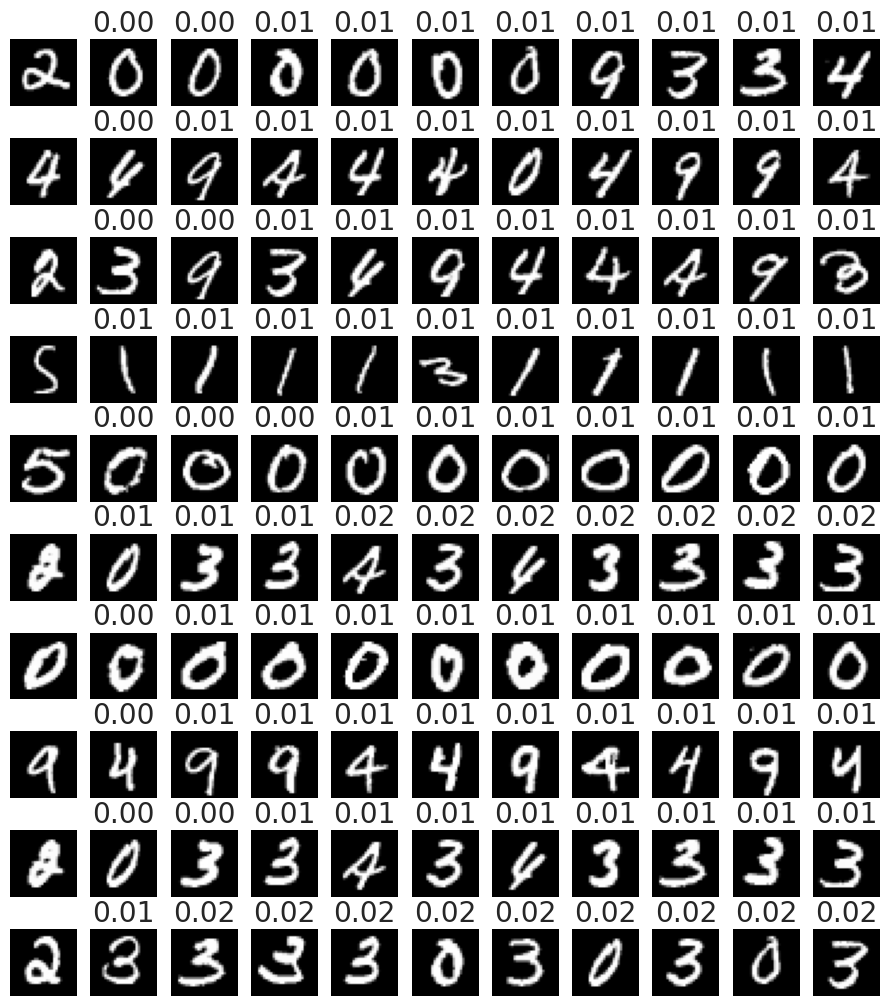

In [220]:
closest_dist, closest_idx = image_search(X_sender, X_receiver,  reducer_callable=partial(autoencoder_reducer, autoencoder=autoencoder), metric="cosine")
viz_image_search(X_sender, X_receiver, closest_idx, closest_dist)

In [221]:
ae_testing_retrieval_acc = compute_img_search_quality(X_sender, X_receiver, y_sender, y_receiver, closest_idx)
print(ae_testing_retrieval_acc.mean())
# filter out all rows that have 2 and 5 labels (OOD)
in_dist_testing_acc = ae_testing_retrieval_acc[(y_sender != 2) & (y_sender != 5)]
print(in_dist_testing_acc.mean())

tensor(0.4644)
tensor(0.7740)


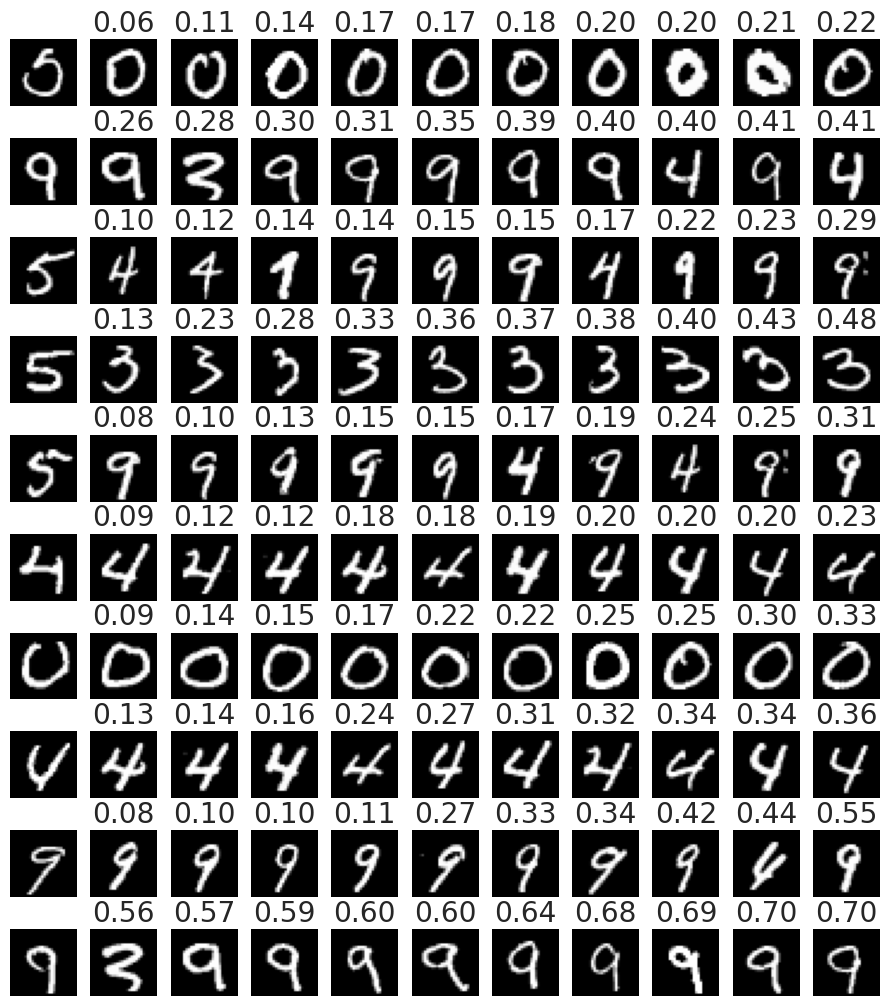

In [169]:
closest_dist, closest_idx = image_search(X_sender, X_receiver,  reducer_callable=partial(clustering_reducer, reducer=reducer))
viz_image_search(X_sender, X_receiver, closest_idx, closest_dist)

In [170]:
clustering_testing_retrieval_acc = compute_img_search_quality(X_sender, X_receiver, y_sender, y_receiver, closest_idx)
print(clustering_testing_retrieval_acc.mean())
# filter out all rows that have 2 and 5 labels (OOD)
in_dist_testing_acc = clustering_testing_retrieval_acc[(y_sender != 2) & (y_sender != 5)]
print(in_dist_testing_acc.mean())

tensor(0.4287)
tensor(0.7146)


## Outliers

In [171]:
# get the loss distribution of the autoencoder on the training data
train_dataloader = torch.utils.data.DataLoader(
    receiver_data,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

losses = []
for batch in train_dataloader:
    losses.append(autoencoder.test_step(batch))
len(losses)

320

In [172]:
# identify the upper bound of the loss distribution as k-standard deviations away from the mean
k = 3
mean = np.mean(losses)
std = np.std(losses)
upper_bound = mean + k * std

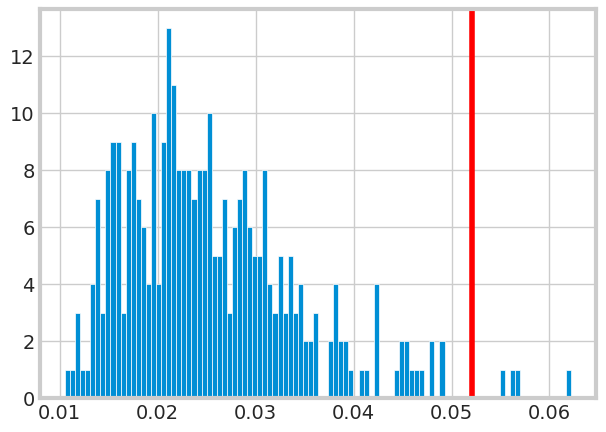

In [173]:
# plot the loss distribution
plt.hist(losses, bins=100);
# draw a vertical line at the upper bound
plt.axvline(x=upper_bound, color="red");

In [174]:
def get_outliers(model, x, upper_bound):
    # x = (batch_size, 1, 28, 28)
    x = x.to(model.device)
    model.net.eval()
    criterion = nn.MSELoss(reduce=False)
    with torch.no_grad():
        reconstructed = model.net(x)
        loss = criterion(reconstructed, x).mean(dim=(1, 2, 3))
    return (loss > upper_bound).cpu(), loss.cpu()

In [175]:
def viz_outliers(outliers, losses, outlier_idx, X):
    n_samples = min(10, len(outliers))
    print(f"Found {len(outliers)} outliers")
    # plot the outliers
    fig, axes = plt.subplots(nrows=2, ncols=n_samples, figsize=(20, 2));
    for i in range(n_samples):
        if n_samples < len(outliers):
            random_idx = np.random.randint(0, len(outliers))
        else:
            random_idx = i
        axes[0, i].imshow(X[outlier_idx][random_idx].cpu().squeeze(), cmap="gray");
        axes[0, i].title.set_text(f"{losses[outlier_idx][random_idx]:.4f}");
        # plot the reconstructed image
        axes[1, i].imshow(autoencoder.net(X[outlier_idx][random_idx].unsqueeze(0).to(autoencoder.device)).squeeze().cpu().detach(), cmap="gray");
        axes[0, i].axis("off");
        axes[1, i].axis("off");

/home/vlongle/miniconda3/envs/data-sharing/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Found 4 outliers


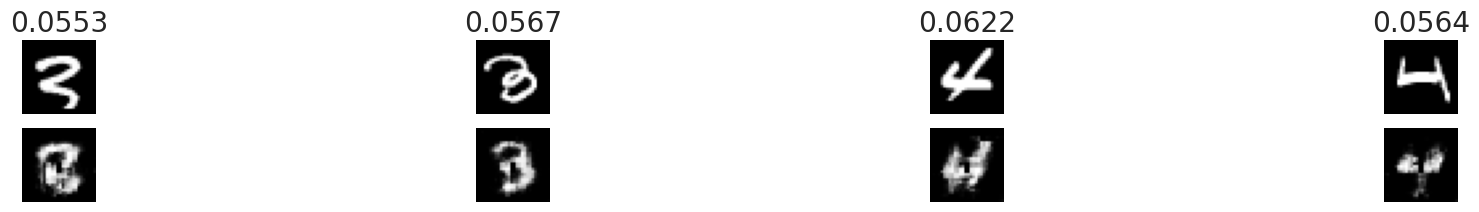

In [176]:
receiver_outliers_idx, losses = get_outliers(autoencoder, X_receiver, upper_bound)
receiver_outliers = X_receiver[receiver_outliers_idx]
viz_outliers(receiver_outliers, losses, receiver_outliers_idx, X_receiver)

In [177]:
torch.unique(y_receiver[receiver_outliers_idx], return_counts=True)

(tensor([3, 4]), tensor([2, 2]))

In [178]:
sender_outliers_idx, losses = get_outliers(autoencoder, X_sender, upper_bound)
sender_outliers = X_sender[sender_outliers_idx]
print(len(sender_outliers))
print(min(losses))

110
tensor(0.0165)


In [179]:
torch.unique(y_sender[sender_outliers_idx], return_counts=True)

(tensor([0, 2, 4, 5, 9]), tensor([ 9, 50, 11, 38,  2]))

Found 110 outliers


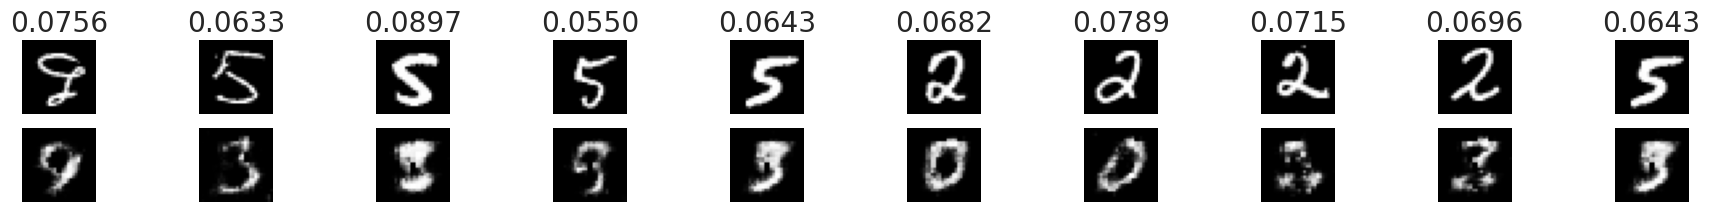

In [180]:
viz_outliers(sender_outliers, losses, sender_outliers_idx, X_sender)

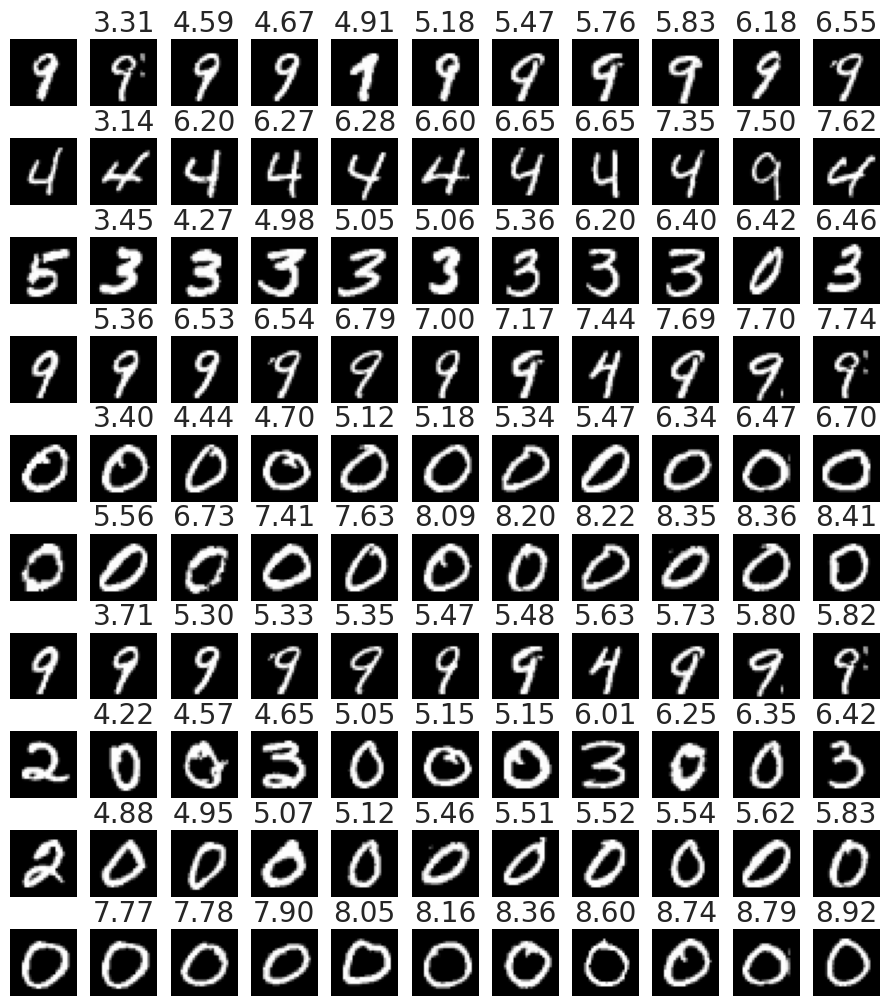

In [182]:
# try the ae image similarity again, this time with the outlier filter...
closest_dist, closest_idx = image_search(X_sender, X_receiver,  reducer_callable=partial(autoencoder_reducer, autoencoder=autoencoder))
viz_image_search(X_sender, X_receiver, closest_idx, closest_dist)

In [186]:
ae_testing_retrieval_acc = compute_img_search_quality(X_sender, X_receiver, y_sender, y_receiver, closest_idx)
print(ae_testing_retrieval_acc.mean())
# filter out all rows that have 2 and 5 labels (OOD)
out_dist_testing_acc = ae_testing_retrieval_acc[sender_outliers_idx]
in_dist_testing_acc = ae_testing_retrieval_acc[~sender_outliers_idx]
print(out_dist_testing_acc.mean())
print(in_dist_testing_acc.mean())

tensor(0.4631)
tensor(0.1473)
tensor(0.6286)
